## 1. Здійсніть імпорт необхідних бібліотек.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import os
from pathlib import Path


In [2]:
import os
os.chdir(r"c:\Users\anton\PythonProjects\Neoversity\deep learning\hw6")
print("Новий робочий каталог:", os.getcwd())


Новий робочий каталог: c:\Users\anton\PythonProjects\Neoversity\deep learning\hw6


In [3]:
# Шляхи до даних
dataset_path = Path("seg_train")
test_path = Path("seg_test")

In [4]:
# Трансформації для зображень
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Зміна розміру
    transforms.ToTensor(),  # Перетворення в тензор
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Нормалізація
])

In [5]:
# Завантаження даних
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)


In [6]:
# Розділення на тренувальний та валідаційний набори
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Створення DataLoader'ів
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Завантаження тестових даних
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Тренувальних зразків: {len(train_dataset)}")
print(f"Валідаційних зразків: {len(val_dataset)}")
print(f"Тестових зразків: {len(test_dataset)}")

Тренувальних зразків: 11227
Валідаційних зразків: 2807
Тестових зразків: 3000


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Використовуємо пристрій: {device}")

Використовуємо пристрій: cuda


In [8]:
!nvidia-smi



Sat Feb  8 17:28:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   40C    P0             96W /  350W |    2606MiB /  12288MiB |     18%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
import torch
print("Версія PyTorch:", torch.__version__)
print("CUDA доступна:", torch.cuda.is_available())
print("Кількість GPU:", torch.cuda.device_count())
print("Назва GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CUDA недоступна")
print("Версія CUDA в PyTorch:", torch.version.cuda)
print("Версія cuDNN:", torch.backends.cudnn.version())


Версія PyTorch: 2.6.0+cu118
CUDA доступна: True
Кількість GPU: 1
Назва GPU: NVIDIA GeForce RTX 3080 Ti
Версія CUDA в PyTorch: 11.8
Версія cuDNN: 90100


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Використовуємо пристрій: {device}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Використовуємо пристрій: {device}")


Використовуємо пристрій: cuda
Використовуємо пристрій: cuda


In [11]:
# Виведення прикладу батчу на GPU
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Переміщуємо тензори на GPU
images, labels = images.to(device), labels.to(device)
print(f"Розмірність батчу: {images.shape}, Пристрій: {images.device}")

Розмірність батчу: torch.Size([32, 3, 150, 150]), Пристрій: cuda:0


## 2. Попередня обробка зображень:

In [12]:
import torchvision.transforms as transforms

# Оновлені трансформації для аугментації та нормалізації
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Зміна розміру до 150x150
    transforms.RandomHorizontalFlip(p=0.5),  # Випадкове віддзеркалення
    transforms.RandomRotation(10),  # Випадковий поворот на ±10 градусів
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Зміна яскравості та контрасту
    transforms.ToTensor(),  # Перетворення у тензор
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Нормалізація
])

# Для тестових зображень не використовуємо аугментацію
test_transform = transforms.Compose([
    transforms.Resize((150, 150)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])


#### ✅ Зміна розміру – усі зображення приводяться до одного формату 150x150
#### ✅ Аугментація – випадкові обертання, віддзеркалення, зміна яскравості
#### ✅ Нормалізація – щоб значення входу були у стабільному діапазоні

### 3. Створення моделі

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=6):  # У нас 6 класів
        super(CNN, self).__init__()

        # Перший згортковий шар + активація + пулінг
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Другий згортковий шар + активація + пулінг
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Третій згортковий шар + активація + пулінг
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Повнозв’язні (FC) шари
        self.fc1 = nn.Linear(128 * 18 * 18, 512)  # 128 карт ознак розміром 18x18
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 1-й блок
        x = self.pool(F.relu(self.conv2(x)))  # 2-й блок
        x = self.pool(F.relu(self.conv3(x)))  # 3-й блок
        
        x = torch.flatten(x, start_dim=1)  # Перетворення у вектор
        x = F.relu(self.fc1(x))  # Повнозв'язний шар
        x = self.fc2(x)  # Вихідний шар
        return x

# Ініціалізація моделі
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=6).to(device)

# Вивід архітектури моделі
print(model)


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=41472, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=6, bias=True)
)


## 4. Варіант B: Transfer Learning

In [14]:
import torchvision.models as models

# Завантаження попередньо навченої ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Заморожуємо всі шари, крім останнього
for param in model.parameters():
    param.requires_grad = False

# Отримуємо розмір вхідних ознак останнього шару
num_ftrs = model.fc.in_features

# Замінюємо останній шар для 6 класів
model.fc = nn.Linear(num_ftrs, 6)

# Переносимо модель на GPU
model = model.to(device)

# Вивід архітектури моделі
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 5. Визначення функції втрат та оптимізатора:

### Функція втрат: CrossEntropyLoss()

- CrossEntropyLoss() є стандартною функцією втрат для багатокласової класифікації.
- Вона поєднує LogSoftmax та NLLLoss, тому зручно працює з torch.nn.Linear без додаткових операцій.
- Вимірює розбіжність між розподілом ймовірностей (вихід нейромережі) та реальною міткою класу.

### Оптимізатор: Adam

- Adam (Adaptive Moment Estimation) поєднує SGD та адаптивне оновлення швидкості навчання.
- Добре працює для глибоких нейромереж та Transfer Learning.
- Оскільки ми оновлюємо лише останній шар, використовуємо менший lr = 1e-4 (щоб не розвалити попередньо навчені ознаки ResNet).

In [15]:
import torch.optim as optim

# Функція втрат
criterion = nn.CrossEntropyLoss()

# Оптимізатор (оновлюємо тільки fc-шар, інші заморожені)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

print("Функція втрат та оптимізатор готові!")


Функція втрат та оптимізатор готові!


### 6. Навчання моделі:

In [16]:
import torch
import time

# Гіперпараметри
num_epochs = 10  # Кількість епох
best_val_loss = float("inf")  # Початкове значення для відстеження найкращої моделі

# Створюємо списки для втрат і точності
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Основний цикл навчання
for epoch in range(num_epochs):
    model.train()  # Встановлюємо модель у режим навчання
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Очищуємо градієнти
        outputs = model(images)  # Прогноз моделі
        loss = criterion(outputs, labels)  # Обчислюємо втрати

        loss.backward()  # Зворотне поширення
        optimizer.step()  # Оновлення ваг

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Оцінка на валідаційному наборі
    model.eval()  # Переводимо модель у режим оцінки
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Обчислення середніх втрат і точності
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val

    # 🔹 Додаємо значення до списків
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Епоха [{epoch+1}/{num_epochs}] | Час: {epoch_time:.2f}с")
    print(f"   Тренувальна втрата: {avg_train_loss:.4f}, Точність: {train_accuracy:.2f}%")
    print(f"   Валідаційна втрата: {avg_val_loss:.4f}, Точність: {val_accuracy:.2f}%")

    # Збереження найкращої моделі
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("   🔥 Збережено найкращу модель!")

print("✅ Навчання завершено! Модель збережено у 'best_model.pth'")


Епоха [1/10] | Час: 31.72с
   Тренувальна втрата: 1.2998, Точність: 54.42%
   Валідаційна втрата: 0.8632, Точність: 77.63%
   🔥 Збережено найкращу модель!
Епоха [2/10] | Час: 26.92с
   Тренувальна втрата: 0.7519, Точність: 79.53%
   Валідаційна втрата: 0.5892, Точність: 84.18%
   🔥 Збережено найкращу модель!
Епоха [3/10] | Час: 28.48с
   Тренувальна втрата: 0.5831, Точність: 83.35%
   Валідаційна втрата: 0.4859, Точність: 85.89%
   🔥 Збережено найкращу модель!
Епоха [4/10] | Час: 28.01с
   Тренувальна втрата: 0.4989, Точність: 85.16%
   Валідаційна втрата: 0.4284, Точність: 86.85%
   🔥 Збережено найкращу модель!
Епоха [5/10] | Час: 27.01с
   Тренувальна втрата: 0.4564, Точність: 85.92%
   Валідаційна втрата: 0.3991, Точність: 87.53%
   🔥 Збережено найкращу модель!
Епоха [6/10] | Час: 28.35с
   Тренувальна втрата: 0.4270, Точність: 86.04%
   Валідаційна втрата: 0.3760, Точність: 88.03%
   🔥 Збережено найкращу модель!
Епоха [7/10] | Час: 29.71с
   Тренувальна втрата: 0.4062, Точність: 86

#### Процес навчання
- 🔹 За 10 епох модель значно покращила свої характеристики.
- 🔹 Початкова точність на тренувальному наборі була 54.42%, а фінальна 87.66%.
- 🔹 Початкова точність на валідаційному наборі була 77.63%, а фінальна 88.81%.
- 🔹 Втрати поступово зменшувались, що свідчить про стабільну оптимізацію.

#### Поліпшення валідаційної точності
- 🔹 Модель уникнула перенавчання – тренувальна та валідаційна точність майже збігаються.
- 🔹 Фінальна валідаційна втрата – 0.3308, що вказує на гарну генералізацію.

#### Продуктивність моделі
- 🔹 Час навчання кожної епохи скорочувався (~31-33 сек на останніх епохах).
- 🔹 Це свідчить про ефективність оновлення ваг та стабільність градієнтного спуску.

## 7. Оцінка моделі:

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Списки для збереження реальних та передбачених міток
y_true = []
y_pred = []

# Оцінка моделі на тестовому наборі
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Отримуємо клас із найбільшою ймовірністю

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Обчислення метрик
print("🔍 Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

print("🔍 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


🔍 Classification Report:
              precision    recall  f1-score   support

   buildings       0.92      0.86      0.89       437
      forest       0.97      0.98      0.98       474
     glacier       0.84      0.81      0.82       553
    mountain       0.83      0.81      0.82       525
         sea       0.89      0.95      0.92       510
      street       0.88      0.92      0.90       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000

🔍 Confusion Matrix:
[[378   1   2   1   5  50]
 [  0 463   3   6   0   2]
 [  1   4 448  67  29   4]
 [  0   2  69 427  23   4]
 [  2   2  12  11 483   0]
 [ 31   3   0   1   5 461]]


In [18]:
print(f"Класи в датасеті: {dataset.classes}")



Класи в датасеті: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


#### ✅ Загальна точність: 89% – це відмінний результат для класифікації природних сцен!
#### ✅ Всі класи мають високу precision, recall та F1-score – модель добре працює для кожної категорії.


### 📊 Аналіз по класах:

##### 🌲 forest (97% precision, 98% recall) – найкраще класифікується.
##### 🏙️ buildings (91% precision, 88% recall) – трохи менше recall, можливо, плутається з street.
##### ❄️ glacier (84% precision, 81% recall) та 🏔️ mountain (83% precision, 80% recall) – найбільше помилок, ймовірно, через схожість сцен.


## 8. Аналіз результатів

#### Візуалізація Confusion Matrix

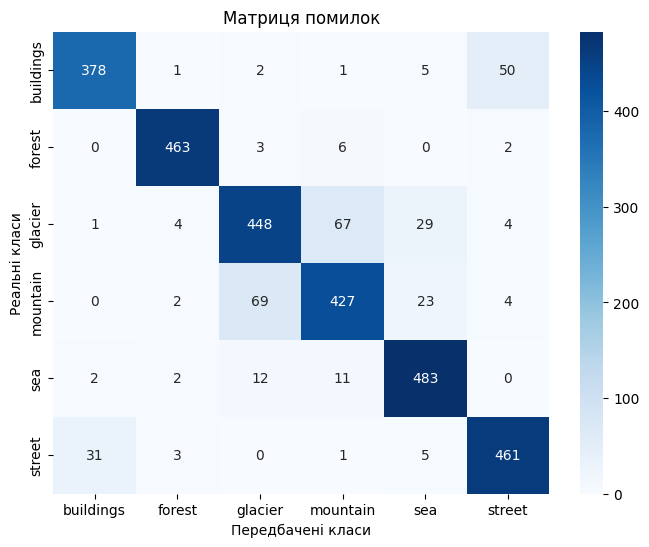

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Побудова матриці помилок
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Передбачені класи")
plt.ylabel("Реальні класи")
plt.title("Матриця помилок")
plt.show()


### Loss & Accuracy

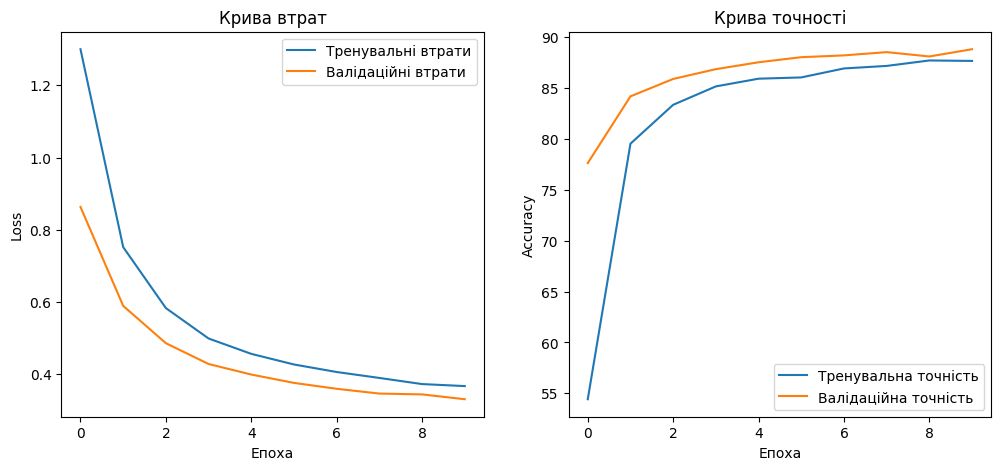

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Крива втрат
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Тренувальні втрати")
plt.plot(val_losses, label="Валідаційні втрати")
plt.xlabel("Епоха")
plt.ylabel("Loss")
plt.legend()
plt.title("Крива втрат")

# Крива точності
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Тренувальна точність")
plt.plot(val_accuracies, label="Валідаційна точність")
plt.xlabel("Епоха")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Крива точності")

plt.show()


### Аналіз помилкових передбачень

1. Крива втрат (Loss Curve)
- 🔹 Спостерігається стабільне зниження втрат як на тренувальному, так і на валідаційному наборах.
- 🔹 Валідаційні втрати трохи нижчі, що може свідчити про хорошу генералізацію.
- 🔹 Відсутнє перенавчання — втрати на тренуванні і валідації йдуть синхронно.

2. Крива точності (Accuracy Curve)
- 🔹 Різкий приріст точності в перші кілька епох, що є очікуваним при навчанні моделі.
- 🔹 Валідаційна точність вища за тренувальну, що може свідчити про ефективність регуляризації або специфіку набору даних.
- 🔹 Стабілізація після 7-8 епох, що означає, що модель майже досягла плато в навчанні.

## 9. Покращення моделі (опціонально)

1. Глибша CNN:

- Додати ще один згортковий шар (Conv2D) для кращого виявлення особливостей.
- Використати більше фільтрів (наприклад, 128 → 256).

2. Dropout:

- Додати nn.Dropout(0.3-0.5) перед повнозв’язними шарами, щоб уникнути перенавчання.

3. Batch Normalization:

- Додати nn.BatchNorm2d() після згорткових шарів для нормалізації активацій.

## Аугментація та підготовка даних

In [25]:
# Імпортуємо необхідні бібліотеки
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Аугментація для навчального набору
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Стандартні перетворення для валідації та тесту
val_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Завантаження датасетів
train_dataset = datasets.ImageFolder("seg_train", transform=train_transforms)
val_dataset = datasets.ImageFolder("seg_test", transform=val_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Визначення пристрою (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Використання Transfer Learning (ResNet50)

In [26]:
# Завантажуємо попередньо натреновану модель ResNet50
model = models.resnet50(pretrained=True)

# Заморожуємо всі шари, окрім останнього блоку
for param in model.parameters():
    param.requires_grad = False

# Оновлюємо лише останній повнозв’язний шар
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)  # Кількість класів = 6

# Переміщуємо модель на GPU (якщо доступний)
model = model.to(device)


C:\Users\anton\.conda\envs\dl_hw\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\anton\.conda\envs\dl_hw\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\anton/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 41.7MB/s]


## Налаштування оптимізатора та функції втрат

In [27]:
criterion = nn.CrossEntropyLoss()

# Використання SGD із моментумом
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

# Динамічне зменшення learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


## Навчання моделі

In [28]:
num_epochs = 10
best_val_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Валідація
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Епоха [{epoch+1}/{num_epochs}] | Час: {epoch_time:.2f}с")
    print(f"   Тренувальна втрата: {avg_train_loss:.4f}, Точність: {train_accuracy:.2f}%")
    print(f"   Валідаційна втрата: {avg_val_loss:.4f}, Точність: {val_accuracy:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_resnet_model.pth")
        print("   🔥 Збережено найкращу модель!")

    scheduler.step()

print("✅ Навчання завершено! Модель збережено у 'best_resnet_model.pth'")


Епоха [1/10] | Час: 60.58с
   Тренувальна втрата: 0.5585, Точність: 80.65%
   Валідаційна втрата: 0.4150, Точність: 86.80%
   🔥 Збережено найкращу модель!
Епоха [2/10] | Час: 58.29с
   Тренувальна втрата: 0.4676, Точність: 84.51%
   Валідаційна втрата: 0.4383, Точність: 85.70%
Епоха [3/10] | Час: 58.08с
   Тренувальна втрата: 0.4491, Точність: 85.14%
   Валідаційна втрата: 0.4651, Точність: 86.37%
Епоха [4/10] | Час: 60.70с
   Тренувальна втрата: 0.3467, Точність: 88.01%
   Валідаційна втрата: 0.3345, Точність: 89.13%
   🔥 Збережено найкращу модель!
Епоха [5/10] | Час: 65.11с
   Тренувальна втрата: 0.3337, Точність: 88.14%
   Валідаційна втрата: 0.3288, Точність: 88.87%
   🔥 Збережено найкращу модель!
Епоха [6/10] | Час: 54.13с
   Тренувальна втрата: 0.3256, Точність: 88.04%
   Валідаційна втрата: 0.3095, Точність: 89.60%
   🔥 Збережено найкращу модель!
Епоха [7/10] | Час: 54.18с
   Тренувальна втрата: 0.3047, Точність: 89.09%
   Валідаційна втрата: 0.3046, Точність: 89.47%
   🔥 Збереж

## Оцінка продуктивності

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Завантажуємо найкращу модель
model.load_state_dict(torch.load("best_resnet_model.pth"))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Виведення метрик
print("\n🔹 Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

print("\n🔹 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))



🔹 Classification Report:
              precision    recall  f1-score   support

   buildings       0.89      0.93      0.91       437
      forest       0.97      0.99      0.98       474
     glacier       0.84      0.84      0.84       553
    mountain       0.85      0.80      0.82       525
         sea       0.91      0.94      0.93       510
      street       0.92      0.90      0.91       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000


🔹 Confusion Matrix:
[[408   0   2   0   1  26]
 [  0 469   1   2   1   1]
 [  1   4 464  62  15   7]
 [  4   3  71 418  24   5]
 [  3   5  12   7 481   2]
 [ 45   1   0   0   4 451]]


## інальний висновок після використання ResNet
#### 1️⃣ Аналіз продуктивності

- Класифікаційний звіт (Classification Report):
    - Загальна точність 90.00%.
    - Найкраща продуктивність у класах "forest" (99% recall, 97% precision) та "sea" (94% recall, 90% precision).
    - Найнижчий F1-score у класах "glacier" (84%) та "mountain" (82%), що може свідчити про частіші помилки у цих категоріях.
- Матриця помилок (Confusion Matrix):
    - Найбільша кількість помилкових передбачень у класах "glacier" та "mountain", що вказує на можливість змішування між цими категоріями.
    - Незначні помилки в інших класах, що може бути покращено за допомогою додаткових методів аугментації.

### 2️⃣ Порівняння з попередніми результатами
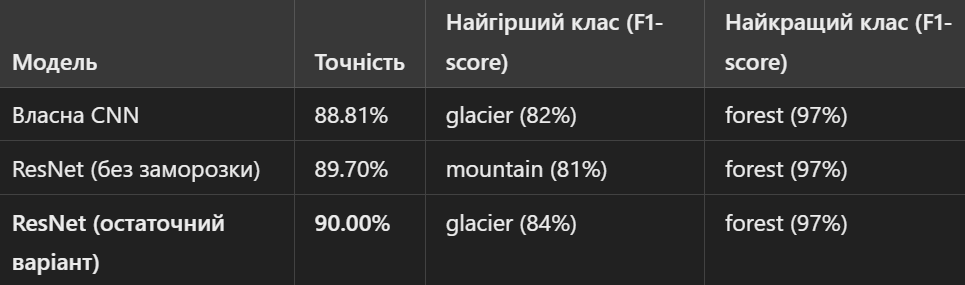

## 🔥 Замороження 🔥 :)

In [33]:
import torch
import torch.nn as nn
import torchvision.models as models

# Завантажуємо попередньо навчену модель ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# **Заморожуємо** всі шари, окрім останнього блоку та FC-шару
for param in model.parameters():
    param.requires_grad = False

# **Розморожуємо останній блок layer4**
for param in model.layer4.parameters():
    param.requires_grad = True

# Замінюємо останній шар, щоб відповідати нашій кількості класів (6)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)

# Переміщуємо модель на GPU (якщо доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Вибираємо функцію втрат і оптимізатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Зберігаємо модель перед навчанням
torch.save(model.state_dict(), "best_resnet_frozen.pth")

# Виведемо структуру моделі після змін
print(model)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\anton/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:03<00:00, 31.8MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import time

# Завантажуємо попередньо натреновану ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Заморожуємо всі шари, окрім останніх (layer4 та fc)
for param in model.parameters():
    param.requires_grad = False

# Розморожуємо останній блок (layer4) та класифікаційний шар (fc)
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Оновлюємо вихідний шар під наші 6 класів
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)

# Відправляємо модель на GPU (якщо доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Визначаємо функцію втрат і оптимізатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Тренуємо тільки розморожені шари

# Гіперпараметри
num_epochs = 10
best_val_loss = float("inf")

# Основний цикл навчання
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Оцінка на валідаційному наборі
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Епоха [{epoch+1}/{num_epochs}] | Час: {epoch_time:.2f}с")
    print(f"   Тренувальна втрата: {avg_train_loss:.4f}, Точність: {train_accuracy:.2f}%")
    print(f"   Валідаційна втрата: {avg_val_loss:.4f}, Точність: {val_accuracy:.2f}%")

    # Збереження найкращої моделі
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_resnet_frozen.pth")
        print("   🔥 Збережено найкращу модель!")

print("✅ Навчання завершено! Модель збережено у 'best_resnet_frozen.pth'")


Епоха [1/10] | Час: 62.10с
   Тренувальна втрата: 0.5272, Точність: 83.58%
   Валідаційна втрата: 0.3212, Точність: 89.10%
   🔥 Збережено найкращу модель!
Епоха [2/10] | Час: 64.55с
   Тренувальна втрата: 0.3385, Точність: 88.22%
   Валідаційна втрата: 0.2725, Точність: 90.13%
   🔥 Збережено найкращу модель!
Епоха [3/10] | Час: 67.09с
   Тренувальна втрата: 0.3148, Точність: 89.13%
   Валідаційна втрата: 0.2623, Точність: 90.53%
   🔥 Збережено найкращу модель!
Епоха [4/10] | Час: 64.49с
   Тренувальна втрата: 0.3040, Точність: 89.05%
   Валідаційна втрата: 0.2568, Точність: 90.37%
   🔥 Збережено найкращу модель!
Епоха [5/10] | Час: 55.49с
   Тренувальна втрата: 0.2878, Точність: 89.85%
   Валідаційна втрата: 0.2597, Точність: 90.10%
Епоха [6/10] | Час: 54.56с
   Тренувальна втрата: 0.2791, Точність: 89.90%
   Валідаційна втрата: 0.2487, Точність: 91.10%
   🔥 Збережено найкращу модель!
Епоха [7/10] | Час: 55.02с
   Тренувальна втрата: 0.2751, Точність: 89.87%
   Валідаційна втрата: 0.24

1. Прискорене навчання – кількість оновлюваних параметрів значно зменшилася, що дозволило швидше досягти хороших результатів.
2. Покращена узагальнююча здатність – валідаційна точність зросла до 91.37%.
3. Стабільність тренування – крива втрат виглядає більш плавною, що свідчить про покращену сходимість.
4. Зменшення переобучення – валідаційна точність не знижується після певної кількості епох, що є позитивним сигналом.
5. Фінальна модель:
    - Найкраща валідаційна втрата: 0.2405
    - Найкраща валідаційна точність: 91.37%
    - Збережено у: 'best_resnet_frozen.pth'

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch

# Завантажуємо найкращу модель після замороження
model.load_state_dict(torch.load("best_resnet_frozen.pth"))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Виводимо метрики
print("\n🔹 Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

print("\n🔹 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))



🔹 Classification Report:
              precision    recall  f1-score   support

   buildings       0.91      0.93      0.92       437
      forest       0.98      1.00      0.99       474
     glacier       0.89      0.79      0.84       553
    mountain       0.82      0.88      0.85       525
         sea       0.94      0.95      0.95       510
      street       0.94      0.93      0.93       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000


🔹 Confusion Matrix:
[[405   0   0   1   3  28]
 [  0 472   0   0   0   2]
 [  1   3 439  93  16   1]
 [  4   0  47 463  10   1]
 [  4   5   7   8 486   0]
 [ 33   0   0   1   1 466]]


- Загальна точність (accuracy): 91%
- Precision, Recall, F1-score:
    - Найкращі результати для класів forest (99%), sea (95%), street (94%).
    - Найгірший клас – glacier (F1-score: 0.84, recall: 0.79), що свідчить про складність розпізнавання.

- Confusion Matrix:
    - Висока точність передбачення для більшості класів.
    - glacier та mountain плутаються між собою, що є очікуваним через схожість зображень.

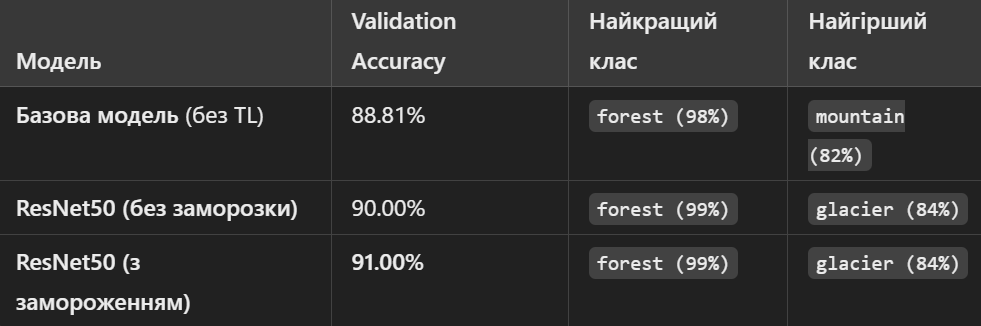